In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
from scipy.spatial import cKDTree

import sys
sys.path.append('../scripts')  # Path relative to the notebook

import cem_utils as utils  # Now you can import it
import buoypy as bp

In [2]:
wave_climate = np.loadtxt('../data/cem/umpqua_wave_climate_data.txt')

Hs = wave_climate[0]
Tp = wave_climate[1]
Dir = wave_climate[2]

xy = np.loadtxt('../data/cem/coquille_pt_coords.txt')

# shoreline
x=xy[:,0]
y=xy[:,1]
dx=100
dy=100

# check the orentation by uncommenting the line below
# plt.plot(x,y)

In [3]:
# Stack and sort by y (column), then x (row)
sorted_indices = np.lexsort((y,x))

# Apply the sorted order
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

#plt.plot(x_sorted,y_sorted)

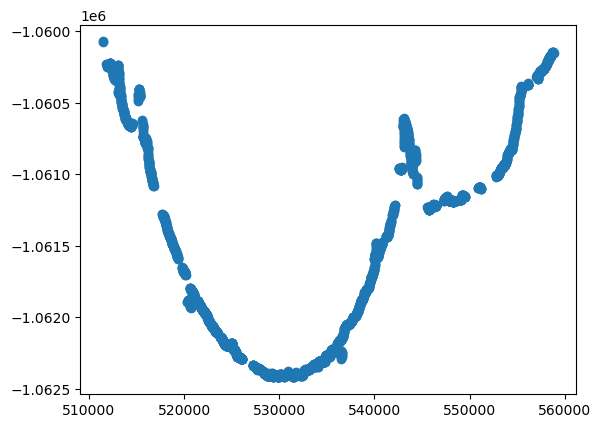

In [4]:
xnew,ynew = utils.rotate_shoreline(x_sorted,y_sorted, -71)

plt.scatter(xnew,ynew)

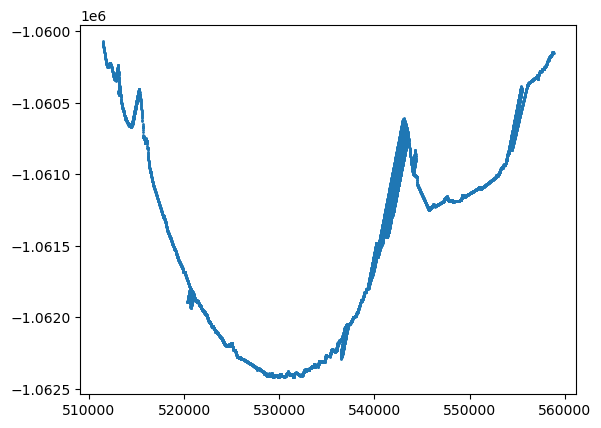

In [5]:
x, y = utils.fill_gaps(xnew, ynew, 10)

# check the orentation by uncommenting the line below
plt.scatter(x,y, s=1)

# if it isnt right, input an angle into the function above and rotate manually
# if it looks good, run the cell below

In [6]:
dx=400
dy=200
xg,yg = utils.shoreline_to_grid(x,y,dx,dy)

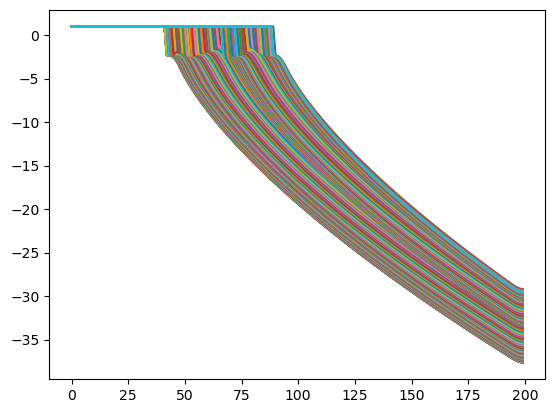

In [7]:
A=0.1 
b=(2/3)
pad=20
zg, dist_map = utils.create_dean_bathy(x,y,xg,yg,pad,A,b)

plt.plot(zg)
plt.show()

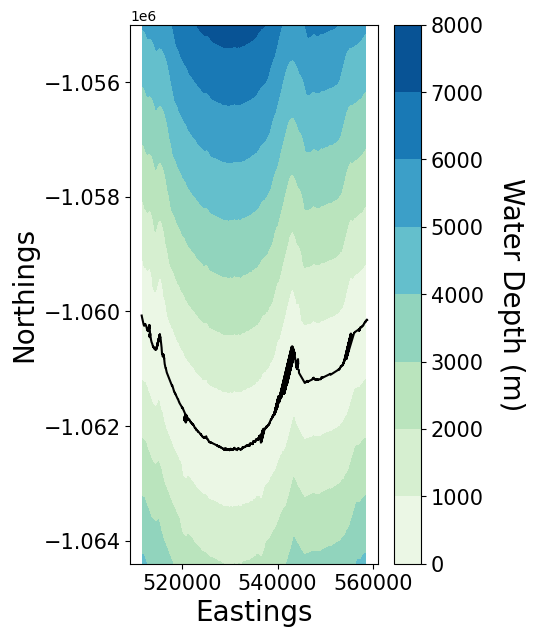

In [8]:
M,N = zg.shape
s = M/N
plt.figure(figsize=(int(s*8),7))
Bathy = plt.contourf(xg, yg, dist_map, cmap=plt.cm.GnBu)
cbar = plt.colorbar(Bathy)
cbar.ax.set_ylabel('Water Depth (m)', fontsize=20, rotation=-90, labelpad=30)
plt.xlabel('Eastings', fontsize=20)
plt.ylabel('Northings', fontsize=20)
plt.tick_params('both', labelsize=15)
cbar.ax.tick_params('y', labelsize=15)
Shore = plt.plot(x, y, 'k')

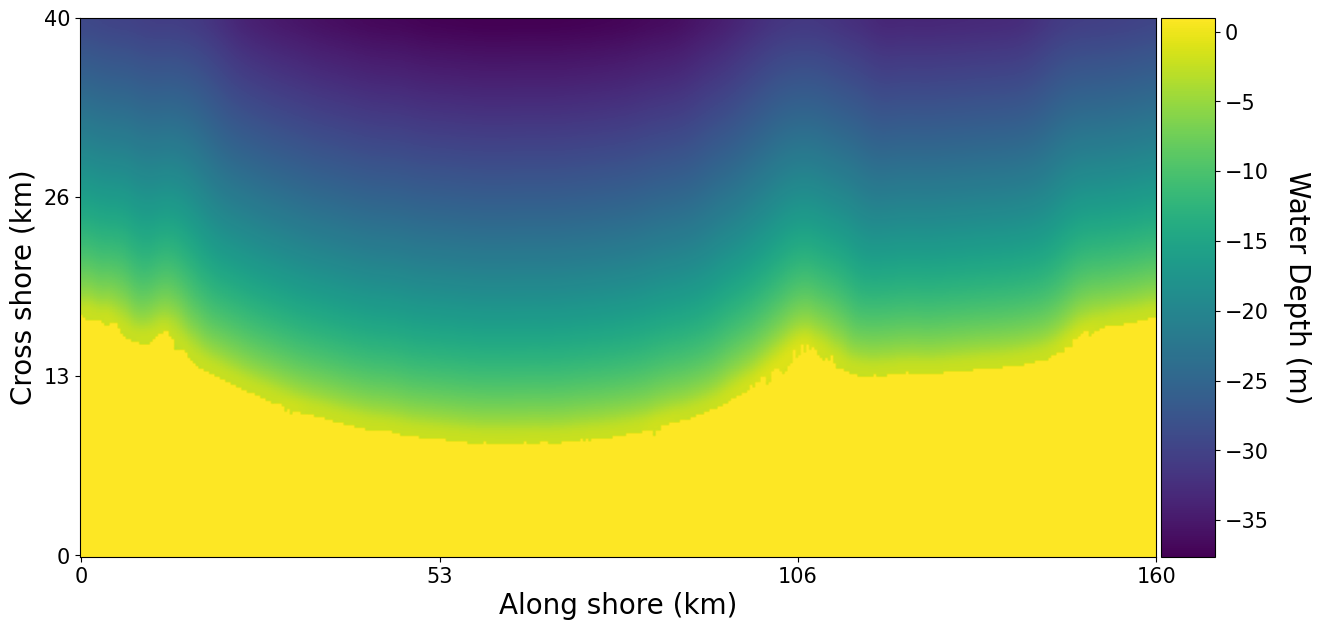

In [9]:
utils.plot_coast(zg,dx,dy)

In [10]:
shelf_slope = utils.find_shelf_slope(zg, dx) ##This should be on the order of 0.001. If not you may need to find this manually
# estimation of shoreface parameters:
shoreface_slope = -4*shelf_slope ## the shoreface is steeper than the shelf
shoreface_depth = 0 # depth meters

In [11]:
from pymt.models import Cem, Waves
cem = Cem()
waves = Waves()
#convert wave direction to asymmetry term
Ap = float(abs((Dir-71)-270)/180)

#convert wave direction to asymmetry term
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'wave_height' : Hs, #meters
    'wave_period' : Tp, #seconds
    'wave_angle_highness': 0.35, #important param
    'wave_angle_asymmetry': Ap
    
}

Setting end time to 3650
CEM: trying to open file: cem.txt
CEM: line: 200, 400, 400, 1

CEM: number of rows, columns: 200, 400
*** Grid size is (0,0)
*** Requested size is (200,800)
*** New grid size is (200,800)


Condition Initial 


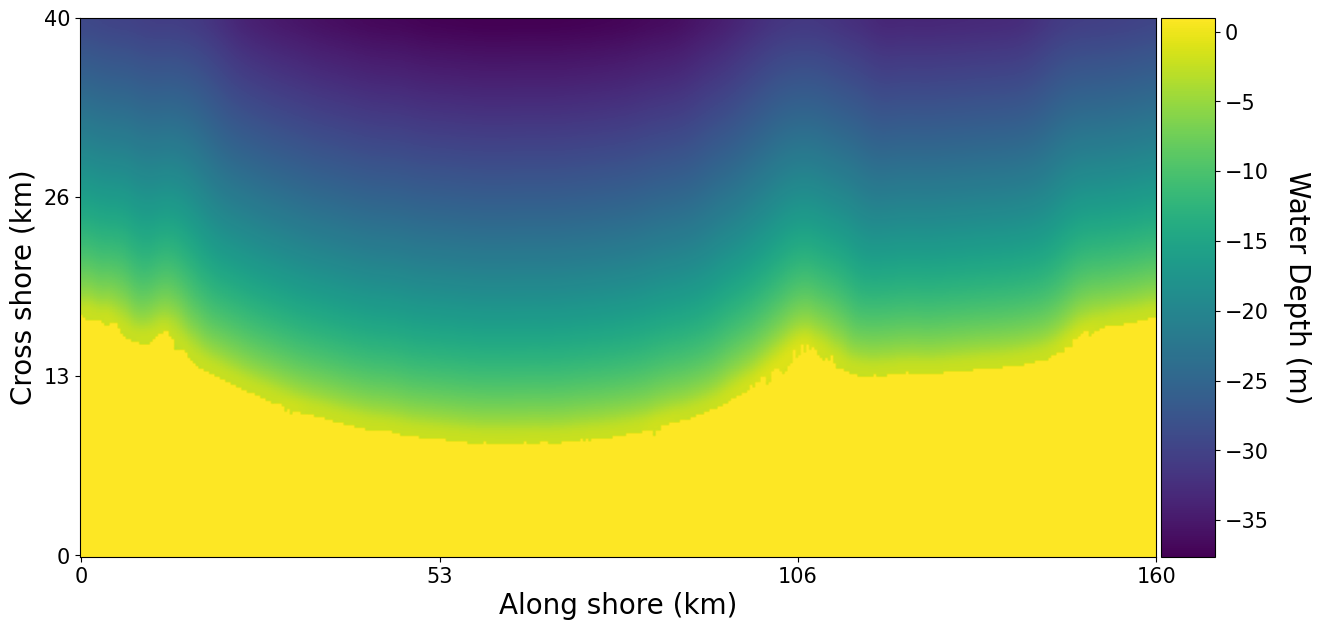

In [12]:
domain = zg
utils.initialize_models(params,domain,cem,waves,set_land=True)
land = cem.get_value('land_surface__elevation')
land = land.reshape(  domain.shape  )
#plot_coast(domain,dx,dy)
utils.plot_coast(land,dx,dy)

/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_70139/3718487285.py:5: DeprecationWarning: Call to deprecated method get_var_units. (use var_units)
  cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")


'kg / s'

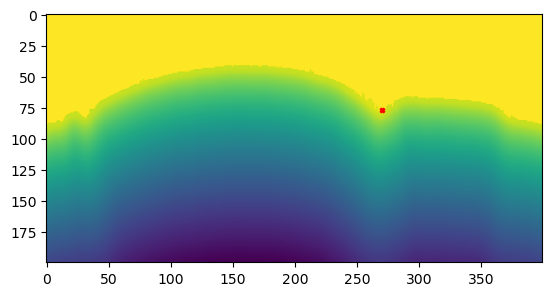

In [13]:
qs = np.zeros_like(land)
qs[77, 275] = 100
plt.imshow(land)
plt.scatter(270, 77, c='r', s=10, marker='X')
cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")

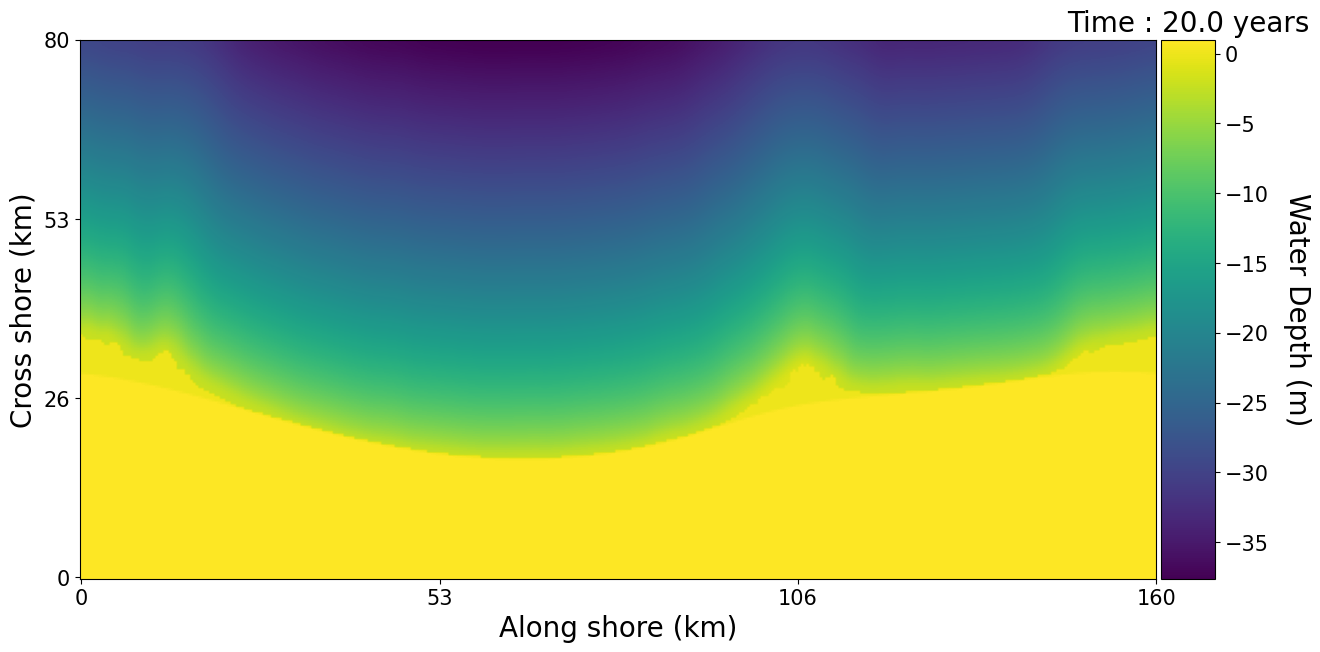

In [14]:
time_years=20
T = int(365*time_years/cem.get_value('model__time_step'))
qs_vec = np.linspace(4,7,T)
n,m = domain.shape
qs_3 = np.zeros((n,m,T))
qs_3[77,270,:] = qs_vec
utils.run_model_loop(time_years, domain ,cem ,waves, qs_3,animate=True,update_ani_years=1)